In [ ]:
!apt-get update
!apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf
!pip install mujoco
!pip install gymnasium[mujoco]
!mkdir -p ~/.mujoco
!wget https://mujoco.org/download/mujoco210-linux-`x86_64.tar.gz -O mujoco.tar.gz
!tar -xvzf mujoco.tar.gz -C ~/.mujoco
!rm mujoco.tar.gz
!wget https://roboti.us/file/mjkey.txt -O ~/.mujoco/mjkey.txt
!pip install imageio[ffmpeg]
!pip install omegaconf

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [53.5 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [917 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,885 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hi

In [ ]:
import os
os.environ['LD_LIBRARY_PATH'] += ':/root/.mujoco/mujoco210/bin'
os.environ['MUJOCO_GL'] = 'egl'

import copy
import random
import collections

import numpy as np
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt

from omegaconf import OmegaConf

from IPython.display import Video, display

In [ ]:
def record_video(env, agent, video_folder):
    state, _ = env.reset()
    terminated, truncated = False, False
    total_reward = 0

    while not (terminated or truncated):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.config.device)
        with torch.no_grad():
            agent.actor.eval()  # 평가 모드로 전환
            action = agent.actor(state_tensor).cpu().detach().numpy().squeeze(0)
            agent.actor.train()  # 학습 모드로 전환

        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state

    env.close()
    return total_reward

In [ ]:
env = gym.make('Walker2d-v4', render_mode='rgb_array')
AC_config = OmegaConf.create({
    # RL parameter
    'gamma': 0.99,

    'buffer_limit': int(1e6),  # increased buffer size for more stability
    'batch_size': 256,  # larger batch size for more stable updates

    # neural network parameters
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'state_dim': env.observation_space.shape[0],
    'action_dim': int(env.action_space.shape[0]),  # cannot use .n because actions are continuous!

    # learning parameters
    'lr_actor': 0.0004,  # lower learning rate for more stable updates
    'lr_critic': 0.0004,  # lower learning rate for more stable updates
    'tau': 0.005,  # soft update parameter

    # noise parameters
    'exploration_theta': 0.15,
    'exploration_sigma': 0.1,
    'policy_theta': 0.15,
    'policy_sigma': 0.1,
    'dt': 0.01,

    # TD3 specific parameters
    'policy_delay': 2,  # frequency of delayed policy updates
})

In [ ]:
class ReplayBuffer():
    def __init__(self, config):
        self.config = config
        self.buffer = collections.deque(maxlen=self.config.buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, next_s_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, next_s, done = transition
            s_lst.append(s.tolist())
            a_lst.append(a.tolist())
            r_lst.append([r])
            next_s_lst.append(next_s.tolist())
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])

        return (
            torch.tensor(s_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(a_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(r_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(next_s_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(done_mask_lst, dtype=torch.float32).to(self.config.device)
        )
    def size(self):
        return len(self.buffer)

In [ ]:
class OrnsteinUhlenbeckNoise:
    def __init__(self, mu, theta, sigma, dt):
        self.theta = theta
        self.sigma = sigma
        self.dt = dt
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

In [ ]:
def soft_update(net, net_target, tau):
    for param_target, param in zip(net_target.parameters(), net.parameters()):
        param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

In [ ]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Defining the first Critic neural network
        self.layer_1 = nn.Linear(state_dim + action_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, 1)

        # Defining the second Critic neural network
        self.layer_4 = nn.Linear(state_dim + action_dim, 400)
        self.layer_5 = nn.Linear(400, 300)
        self.layer_6 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)

        x2 = F.relu(self.layer_4(xu))
        x2 = F.relu(self.layer_5(x2))
        x2 = self.layer_6(x2)

        return x1, x2

    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)
        return x1

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.memory = ReplayBuffer(self.config)
        self.exploration_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(self.config.action_dim), theta=self.config.exploration_theta, sigma=self.config.exploration_sigma, dt=self.config.dt)
        self.policy_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(self.config.action_dim), theta=self.config.policy_theta, sigma=self.config.policy_sigma, dt=self.config.dt)
        self.max_action = env.action_space.high[0]

        # Actor network
        self.actor = nn.Sequential(
            nn.Linear(self.config.state_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, self.config.action_dim),
            nn.Tanh()
        ).to(self.config.device)

        # Single Critic network with two outputs
        self.critic = Critic(self.config.state_dim, self.config.action_dim).to(self.config.device)

        # Target networks
        self.actor_target = copy.deepcopy(self.actor)
        self.critic_target = copy.deepcopy(self.critic)

        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=self.config.lr_actor)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=self.config.lr_critic)

        self.total_it = 0

    def update(self):
        if self.memory.size() < self.config.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.config.batch_size)

        with torch.no_grad():
            noise = torch.tensor(self.policy_noise(), device=self.config.device, dtype=torch.float32)
            noise = torch.clamp(noise, -0.5, 0.5)
            next_actions = self.actor_target(next_states) + noise
            next_actions = torch.clamp(next_actions, -self.max_action, self.max_action)
            target_q1, target_q2 = self.critic_target(next_states, next_actions)
            target_q = rewards + dones * self.config.gamma * torch.min(target_q1, target_q2)

        current_q1, current_q2 = self.critic(states, actions)
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)

        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

        if self.total_it % self.config.policy_delay == 0:
            actor_loss = -self.critic.Q1(states, self.actor(states)).mean()
            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()

            soft_update(self.actor, self.actor_target, self.config.tau)
            soft_update(self.critic, self.critic_target, self.config.tau)
        self.total_it += 1

In [ ]:
env = gym.make('Walker2d-v4', render_mode='rgb_array')
num_epis = 5000
total_run = 0
epi_rews = []
agent = ActorCritic(AC_config)

eval_interval = 100  # 평가 간격
eval_rews = []

for n_epi in tqdm(range(num_epis)):
    state, _ = env.reset()
    terminated, truncated = False, False
    epi_rew = 0

    while not (terminated or truncated):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.config.device)
        with torch.no_grad():
            agent.actor.eval()
            action = agent.actor(state_tensor).cpu().detach().numpy().squeeze(0)
            agent.actor.train()
        noise = agent.exploration_noise()
        noise = np.clip(noise, -0.5, 0.5)
        action += noise
        action = np.clip(action, -agent.max_action, agent.max_action)
        next_state, reward, terminated, truncated, _ = env.step(action)

        agent.memory.put((state, action, reward, next_state, terminated or truncated))

        state = next_state
        epi_rew += reward
        total_run += 1

        if total_run > 25000:
            agent.update()

    epi_rews.append(epi_rew)

    if (n_epi + 1) % eval_interval == 0:
        avg_rew = np.mean(epi_rews[-eval_interval:])
        print(f"Episode {n_epi + 1}: Average Reward: {avg_rew}", f"Total Steps {total_run}, Total Updates {agent.total_it}")
        eval_rews.append(avg_rew)

    if total_run > int(1e6):
      print(f"Total Step {total_run} Exceeded {int(1e6)}")
      break

env.close()

  2%|▏         | 100/5000 [00:08<08:54,  9.18it/s]

Episode 100: Average Reward: 42.49552758986266 Total Steps 9945, Total Updates 0


  4%|▍         | 202/5000 [00:13<03:24, 23.42it/s]

Episode 200: Average Reward: 17.38756977836123 Total Steps 16432, Total Updates 0


  6%|▌         | 304/5000 [00:21<03:59, 19.58it/s]

Episode 300: Average Reward: 64.19131715757705 Total Steps 25081, Total Updates 81


  8%|▊         | 400/5000 [02:09<2:10:43,  1.71s/it]

Episode 400: Average Reward: 191.02265409340424 Total Steps 38791, Total Updates 13791


 10%|█         | 500/5000 [04:26<1:33:07,  1.24s/it]

Episode 500: Average Reward: 228.22723766235256 Total Steps 55902, Total Updates 30902


 12%|█▏        | 600/5000 [06:35<1:19:32,  1.08s/it]

Episode 600: Average Reward: 267.1040055846707 Total Steps 71558, Total Updates 46558


 14%|█▍        | 700/5000 [09:22<2:05:00,  1.74s/it]

Episode 700: Average Reward: 359.12491019847863 Total Steps 91420, Total Updates 66420


 16%|█▌        | 800/5000 [11:51<1:54:03,  1.63s/it]

Episode 800: Average Reward: 328.9778466928148 Total Steps 108700, Total Updates 83700


 18%|█▊        | 900/5000 [14:36<2:12:45,  1.94s/it]

Episode 900: Average Reward: 353.2405647974263 Total Steps 127122, Total Updates 102122


 20%|██        | 1000/5000 [17:58<2:26:46,  2.20s/it]

Episode 1000: Average Reward: 457.0248004193935 Total Steps 148858, Total Updates 123858


 22%|██▏       | 1100/5000 [22:16<3:30:38,  3.24s/it]

Episode 1100: Average Reward: 550.5084763954942 Total Steps 175328, Total Updates 150328


 24%|██▍       | 1200/5000 [27:10<2:59:13,  2.83s/it]

Episode 1200: Average Reward: 659.655803889777 Total Steps 203625, Total Updates 178625


 26%|██▌       | 1300/5000 [32:35<3:43:46,  3.63s/it]

Episode 1300: Average Reward: 781.118599811811 Total Steps 233060, Total Updates 208060


 28%|██▊       | 1400/5000 [39:16<21:15,  2.82it/s]

Episode 1400: Average Reward: 987.7207070231484 Total Steps 267175, Total Updates 242175


 30%|███       | 1500/5000 [49:45<6:31:58,  6.72s/it]

Episode 1500: Average Reward: 1675.3476804455588 Total Steps 316470, Total Updates 291470


 32%|███▏      | 1600/5000 [1:05:07<11:16:56, 11.95s/it]

Episode 1600: Average Reward: 2446.48509737185 Total Steps 382499, Total Updates 357499


 34%|███▍      | 1700/5000 [1:26:00<11:34:46, 12.63s/it]

Episode 1700: Average Reward: 3186.596152604886 Total Steps 462247, Total Updates 437247


 36%|███▌      | 1800/5000 [1:49:04<10:31:42, 11.84s/it]

Episode 1800: Average Reward: 3079.4107441630213 Total Steps 539745, Total Updates 514745


 38%|███▊      | 1900/5000 [2:15:37<15:18:15, 17.77s/it]

Episode 1900: Average Reward: 3189.3064564701513 Total Steps 618872, Total Updates 593872


 40%|████      | 2000/5000 [2:48:54<20:07:23, 24.15s/it]

Episode 2000: Average Reward: 3617.4953550230343 Total Steps 706572, Total Updates 681572


 42%|████▏     | 2100/5000 [3:27:23<22:04:45, 27.41s/it]

Episode 2100: Average Reward: 3752.6307724042113 Total Steps 795572, Total Updates 770572


 44%|████▍     | 2200/5000 [4:10:51<16:50:22, 21.65s/it]

Episode 2200: Average Reward: 3751.404054543296 Total Steps 883984, Total Updates 858984


 46%|████▌     | 2300/5000 [4:53:55<25:13:39, 33.64s/it]

Episode 2300: Average Reward: 3363.784159194084 Total Steps 962699, Total Updates 937699


 47%|████▋     | 2346/5000 [5:16:03<5:57:32,  8.08s/it] 

Total Step 1000334 Exceeded 1000000


In [ ]:
np.mean(epi_rews[-300:])

3589.5120750254664

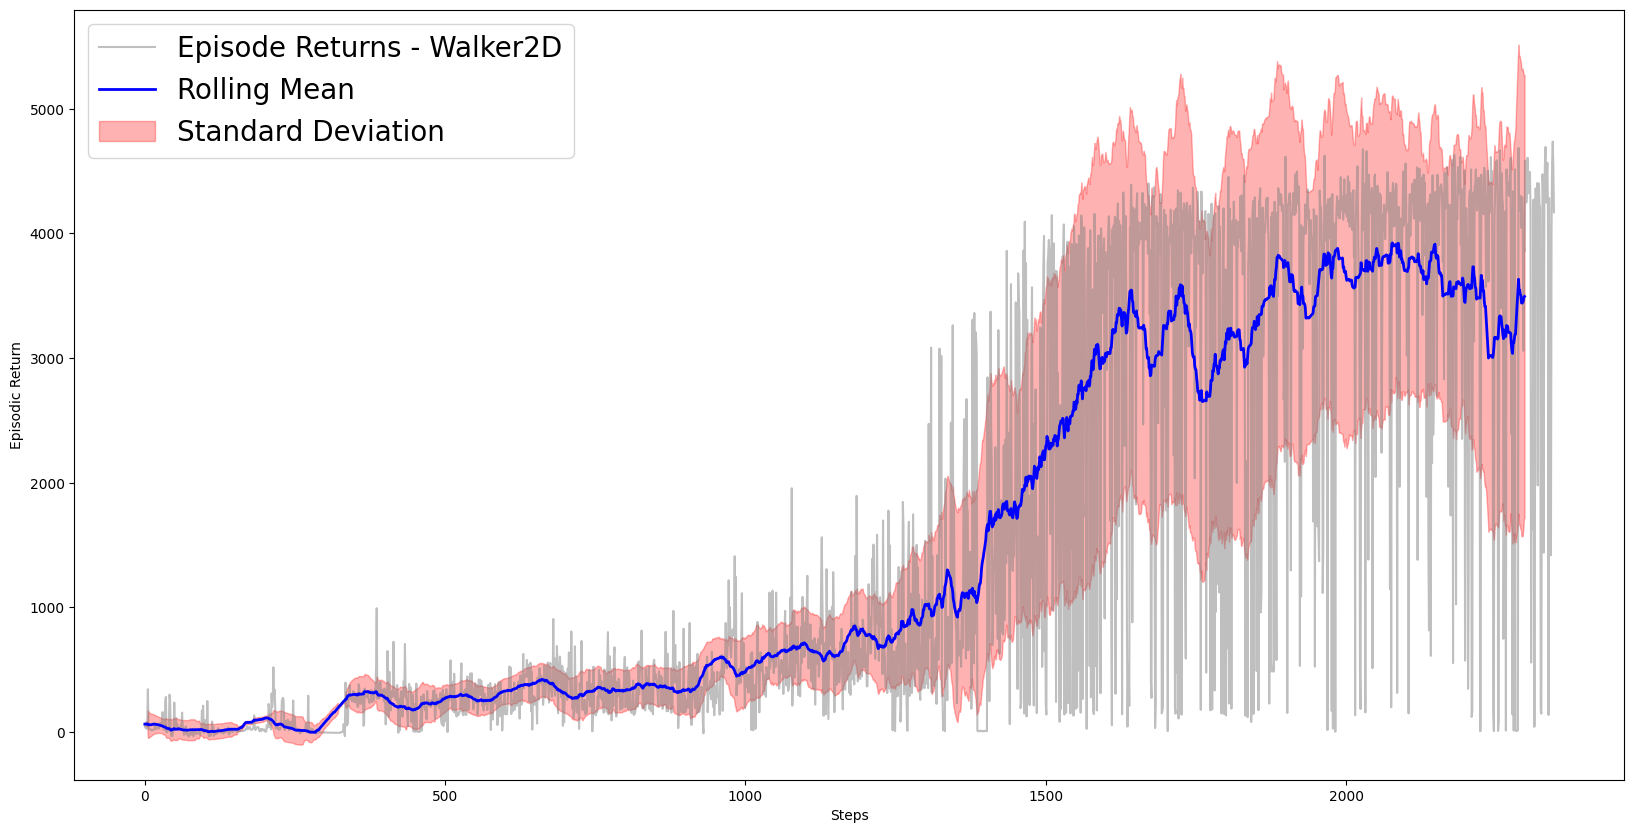

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the rolling mean and standard deviation
window = 50  # Window size for moving average
rolling_mean = np.convolve(epi_rews, np.ones(window)/window, mode='valid')

# Calculate the standard deviation with the same window
rolling_std = np.array([np.std(epi_rews[max(0, i - window + 1):i + 1]) for i in range(len(epi_rews))])
rolling_std = rolling_std[:len(rolling_mean)]  # Match lengths of rolling_mean and rolling_std

# Define the steps variable
steps = np.arange(len(epi_rews))

# Plot the results
plt.figure(figsize=(20, 10))

# Plot the entire episodic returns with a faded color
plt.plot(steps, epi_rews, label='Episode Returns - Walker2D', color='grey', alpha=0.5)

# Plot the rolling mean with a thicker line
plt.plot(steps[:len(rolling_mean)], rolling_mean, color='blue', linewidth=2, label='Rolling Mean')

# Plot the standard deviation as a filled area
plt.fill_between(steps[:len(rolling_mean)], rolling_mean - rolling_std, rolling_mean + rolling_std, color='red', alpha=0.3, label='Standard Deviation')

plt.xlabel('Steps')
plt.ylabel('Episodic Return')
plt.legend(fontsize=20)
plt.show()
plt.close()

In [ ]:
  # 비디오 폴더 생성
video_folder = 'videos'
os.makedirs(video_folder, exist_ok=True)

# 비디오 녹화 및 저장
env = gym.make('Walker2d-v4', render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)
total_reward = record_video(env, agent, video_folder)

print(f"Total reward: {total_reward}")


video_path = os.path.join(video_folder, 'rl-video-episode-0.mp4')
display(Video(video_path, embed=True))

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Total reward: 4239.619298734499
